In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pylab as pl
import matplotlib.pylab as plt

pl.rcParams['font.size'] = 20
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# data

## UberLyft & ticket

In [2]:
df = pd.read_csv('output_final/data_final.csv')
df["date"] = pd.to_datetime(df["date"],format='%Y-%m-%d')
print(df.shape)
df.head()

(333768, 5)


,date,zone,pickup,dropoff,tickets
0,2015-01-01,0.0,28.0,48715.0,0.0
1,2015-01-01,1.0,1.0,0.0,10.0
2,2015-01-01,3.0,9.0,0.0,0.0
3,2015-01-01,4.0,411.0,0.0,43.0
4,2015-01-01,6.0,2.0,0.0,22.0


In [3]:
df.tail()

,date,zone,pickup,dropoff,tickets
333763,2018-06-28,199.0,0.0,0.0,37.0
333764,2018-06-29,105.0,0.0,0.0,72.0
333765,2018-06-29,199.0,0.0,0.0,28.0
333766,2018-06-30,105.0,0.0,0.0,14.0
333767,2018-06-30,199.0,0.0,0.0,19.0


In [4]:
df = df.groupby('date').sum()[['pickup', 'tickets']]

### date range

In [5]:
date_range = pd.date_range('01/01/2015', '06/30/2018', freq='D' )

In [6]:
len(date_range)

1277

## Population & employment & commercial facilities

## Weather data

In [7]:
nycweather = pd.read_csv('nycweather_2014_2018.csv')[['DATE', 'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN']]
nycweather['TAVG'] = nycweather[['TMAX', 'TMIN']].mean(axis=1)
nycweather = nycweather[nycweather[nycweather['DATE']=='2015-01-01'].index[0] : nycweather[nycweather['DATE']=='2018-06-30'].index[0]+1]
nycweather.reset_index(drop=True, inplace=True)
nycweather = nycweather.sort_values('DATE')
nycweather.index = date_range
nycweather.drop(['TMAX', 'TMIN', 'DATE'], axis=1, inplace=True)
nycweather.columns = ['WindSpeed', 'Precipitation', 'Snow', 'Temperature']
print(nycweather.shape)
nycweather.head()

(1277, 4)


,WindSpeed,Precipitation,Snow,Temperature
2015-01-01,7.16,0.00,0.0,33.0
2015-01-02,7.16,0.00,0.0,38.5
2015-01-03,6.49,0.71,0.0,37.5
2015-01-04,6.49,0.30,0.0,48.5
2015-01-05,10.51,0.00,0.0,35.0


In [8]:
nycweather.tail()

,WindSpeed,Precipitation,Snow,Temperature
2018-06-26,3.80,0.00,0.0,69.5
2018-06-27,3.58,0.01,0.0,69.5
2018-06-28,2.91,1.36,0.0,76.5
2018-06-29,2.68,0.00,0.0,79.5
2018-06-30,2.24,0.00,0.0,82.5


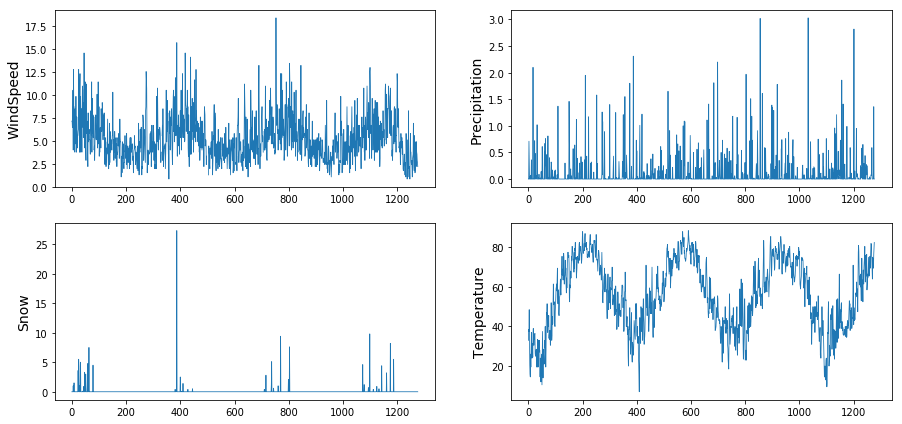

In [9]:
fig = plt.figure(figsize=(15,15))
for i in range(nycweather.shape[1]):
    ax = fig.add_subplot(4,2,i+1)
    ax.plot(range(nycweather.shape[0]), nycweather[nycweather.columns[i]], '-', linewidth=0.8)
    ax.set_ylabel(nycweather.columns[i], fontsize=14)

##  Holiday 
**Whether the day is holiday**

In [10]:
# Generate a list of holidays over this period
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays_all = calendar.holidays(date_range[0], date_range[len(date_range)-1])
holidays_all

DatetimeIndex(['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

In [11]:
print(date_range[2])
calendar.holidays(date_range[1], date_range[2])

2015-01-03 00:00:00


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [12]:
holidays = []
for i in range(len(date_range)):
    holidays.append(len(calendar.holidays(date_range[i-1], date_range[i])))

In [13]:
holidays = pd.DataFrame(holidays)
holidays.index = date_range
holidays.columns = ['holidays']
print(holidays.shape)
holidays.head()

(1277, 1)


,holidays
2015-01-01,0
2015-01-02,1
2015-01-03,0
2015-01-04,0
2015-01-05,0


## Weekdays 
**Whether the day is weekday**<br>
refer to https://cloud.tencent.com/developer/ask/176278

In [14]:
holiday_date_list = holidays_all.date.tolist()

In [15]:
np.busday_count(date_range[0].date(), date_range[len(date_range)-1].date(), holidays = holiday_date_list)

878

In [16]:
np.busday_count(date_range[0].date(), date_range[12].date(), holidays = holiday_date_list)

7

In [17]:
weekdays = []
for i in range(len(date_range)):
    weekdays.append(np.busday_count(date_range[i-1].date(), date_range[i].date(), holidays = holiday_date_list))
weekdays[0] = weekdays[12]

In [18]:
weekdays = pd.DataFrame(weekdays)
weekdays.index = date_range
weekdays.columns = ['weekdays']
print(weekdays.shape)
weekdays.head()

(1277, 1)


,weekdays
2015-01-01,1
2015-01-02,0
2015-01-03,1
2015-01-04,0
2015-01-05,0


## Events data (Missing)
**number & magnitude of events in the date**

## Merge

In [19]:
X = pd.merge(nycweather, holidays, left_index=True, right_index=True, how='left')
X = pd.merge(X, weekdays, left_index=True, right_index=True, how='left')
X = pd.merge(X, df[['pickup']], left_index=True, right_index=True, how='left')
X = X.fillna(0)
print(X.shape)
X.head()

(1277, 7)


,WindSpeed,Precipitation,Snow,Temperature,holidays,weekdays,pickup
2015-01-01,7.16,0.00,0.0,33.0,0,1,48715.0
2015-01-02,7.16,0.00,0.0,38.5,1,0,33877.0
2015-01-03,6.49,0.71,0.0,37.5,0,1,50228.0
2015-01-04,6.49,0.30,0.0,48.5,0,0,34961.0
2015-01-05,10.51,0.00,0.0,35.0,0,0,36290.0


In [20]:
Y = df[['tickets']]

Text(0.5, 1.0, 'Tickets')

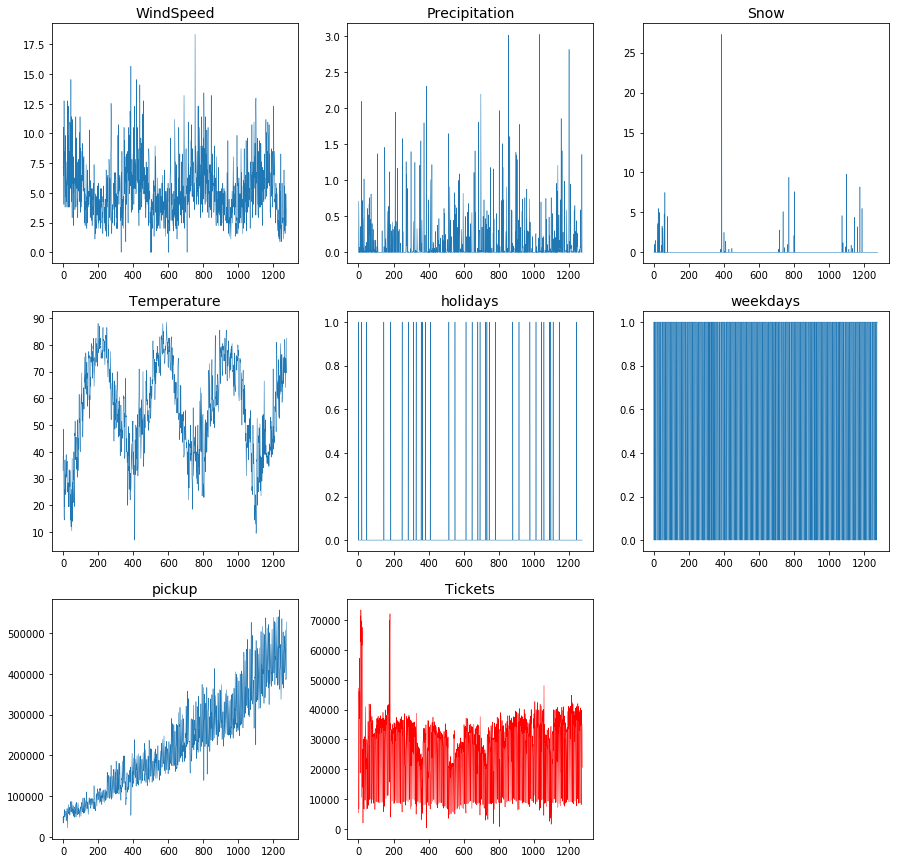

In [21]:
fig = plt.figure(figsize=(15,15))
for i in range(X.shape[1]):
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(range(X.shape[0]), X[X.columns[i]], '-', linewidth=0.5)
    ax.set_title(X.columns[i], fontsize=14)
ax = fig.add_subplot(3,3,i+2)
ax.plot(range(Y.shape[0]), Y, '-', linewidth=0.5, c='r')
ax.set_title("Tickets", fontsize=14)

## standardize

In [22]:
def standardize(time_series):
    return((time_series - mean(time_series)) / std(time_series))

In [23]:
Y = standardize(Y)
Y.head()

,tickets
date,
2015-01-01,-1.938225
2015-01-02,1.858046
2015-01-03,-0.255125
2015-01-04,-1.822499
2015-01-05,1.762364


In [24]:
X = X.apply(standardize)

In [25]:
X.describe()

,WindSpeed,Precipitation,Snow,Temperature,holidays,weekdays,pickup
count,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03,1.277000e+03
mean,1.535359e-16,-3.162875e-16,9.922021e-17,7.998474e-18,2.987256e-16,-1.486673e-16,1.092313e-15
std,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00
min,-2.136430e+00,-3.680129e-01,-1.149385e-01,-2.764959e+00,-2.353123e-01,-1.486117e+00,-1.698927e+00
25%,-6.809712e-01,-3.680129e-01,-1.149385e-01,-7.577164e-01,-2.353123e-01,-1.486117e+00,-8.175990e-01
50%,-1.361904e-01,-3.680129e-01,-1.149385e-01,3.387209e-02,-2.353123e-01,6.728947e-01,-1.373594e-01
75%,5.020975e-01,-2.152126e-01,-1.149385e-01,9.102737e-01,-2.353123e-01,6.728947e-01,6.923560e-01
max,5.319748e+00,8.891682e+00,2.607459e+01,1.843217e+00,4.249671e+00,6.728947e-01,2.715881e+00


## train & test split

In [26]:
X_train = X[:'2017-12-31']
X_test = X['2018-01-01':]
print(len(X_train))
print(len(X_test))

Y_train = Y[:'2017-12-31']
Y_test = Y['2018-01-01':]
print(len(Y_train))
print(len(Y_test))

test = pd.merge(X_test, Y_test, left_index=True, right_index=True).reset_index(drop=True)

1096
181
1096
181


# Multivariate linear regression model

In [27]:
def modelEval(VarSlice, lm, key = 'tickets'):
    lmy = lm.predict(test[VarSlice])
    y_err = lmy - test[key]
    y_norm = test[key]-np.mean(test[key])
    return 1-y_err.dot(y_err)/y_norm.dot(y_norm)  # R2 w.r.t. test set

In [28]:
multimod = sm.OLS(Y_train, X_train).fit()
multimod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tickets   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     48.69
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           2.37e-60
Time:                        10:40:17   Log-Likelihood:                -1399.5
No. Observations:                1096   AIC:                             2813.
Df Residuals:                    1089   BIC:                             2848.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
WindSpeed         0.0317      0.031      1.008      0.314      -0.030       0.093
Precipitation    -0.0973      0.028     -3.441      0.001      -0.153      -0.042
Snow             -0.1373      0.028     -4.826      0.000      -0.193      -0.082
Temperature       0.0314      0.031      1.014      0.311      -0.029       0.092
holidays          0.0310      0.027      1.149      0.251      -0.022       0.084
weekdays          0.4489      0.027     16.417      0.000       0.395       0.503
pickup           -0.1681      0.032     -5.286      0.000      -0.230      -0.106
==============================================================================
Omnibus:                       97.944   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.699
Skew:                           0.550   Prob(JB):                     1.31e-45
Kurtosis:                       4.821   Cond. No.                         1.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
print('In sample R-squared: %f'%multimod.rsquared)
print('Out of sample R-squared: %f'%modelEval(test.columns[:-1],lm=multimod))

In sample R-squared: 0.238390
Out of sample R-squared: 0.095436


# Fixed effect model
https://stackoverflow.com/questions/24195432/fixed-effect-in-pandas-or-statsmodels

In [30]:
from linearmodels import PanelOLS

In [31]:
mod = PanelOLS(Y_train, X_train[['pickup']], entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

ZeroDivisionError: float division by zero